# Importing the Necessary Libraries

In [ ]:
# Install libraries in one line
!pip install nltk wordcloud -q

# Importing necessary libraries
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import requests
import zipfile
import os
import io
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from wordcloud import WordCloud  # Note the correction in import statement
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from urllib.request import urlretrieve
from joblib import load

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

nltk_datasets = ['stopwords', 'wordnet', 'punkt', 'averaged_perceptron_tagger', 'omw-1.4']
for dataset in nltk_datasets:
    nltk.download(dataset, quiet=True)

# Importing the Training Datasets

In [ ]:
# URLs for the datasets
yt_data = 'https://huggingface.co/datasets/vsak/YouTube_spam_translation/raw/main/youtube_translate.csv'
email_data = 'https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip'
sms_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

def download_and_extract_zip(url, extract_to):
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Data extracted successfully to {extract_to}.")
    else:
        print(f"Failed to download the file from {url}. Status code: {response.status_code}")

# Function to load and process CSV data
def load_and_process_csv(path, columns, label_transformation=None, source_label=None, sep=',', header='infer'):
    df = pd.read_csv(path, sep=sep, header=header, usecols=columns)
    if label_transformation:
        df[columns[1]] = df[columns[1]].map(label_transformation)
    df.columns = ['text', 'label']
    if source_label:
        df['source'] = source_label
    return df

# Import and process YouTube reviews dataset
df1 = pd.read_csv(yt_data)
df1 = df1[['Message', 'Category']]
df1.columns = ['text', 'label']
df1['source'] = 'social media'

# Process Email Data
download_and_extract_zip(email_data, "enron_spam_data")
df2 = load_and_process_csv('enron_spam_data/enron_spam_data.csv', ['Message', 'Spam/Ham'], {'spam': 1, 'ham': 0}, 'email')

# Process SMS Data
download_and_extract_zip(sms_data, "sms_data")
extracted_file_path = os.path.join("sms_data", "SMSSpamCollection")
df3 = pd.read_csv(extracted_file_path, sep='\t', header=None, names=['label', 'text'])
df3['label'] = df3['label'].map({'spam': 1, 'ham': 0})
df3['source'] = 'sms'

# Combine all DataFrames
df_unseen = pd.concat([df1, df3])
#df = df1

print(df2.head())
print(df2.info())

source_counts = df2['source'].value_counts()
print(source_counts)

Data extracted successfully to enron_spam_data.
Data extracted successfully to sms_data.
                                                text  label source
0                                                NaN      0  email
1  gary , production from the high island larger ...      0  email
2             - calpine daily gas nomination 1 . doc      0  email
3  fyi - see note below - already done .\nstella\...      0  email
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      0  email
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33345 non-null  object
 1   label   33716 non-null  int64 
 2   source  33716 non-null  object
dtypes: int64(1), object(2)
memory usage: 790.3+ KB
None
email    33716
Name: source, dtype: int64


# Evaluation of the Dataset

In [ ]:
# Check the dataset for missing values
df2.isna().sum()

text      371
label       0
source      0
dtype: int64

In [ ]:
# Calculate the percentages of Spam/Ham
not_spam_ratio = (len(df2[df2['label'] == 0]) / len(df2)) * 100
spam_ratio = (len(df2[df2['label'] == 1]) / len(df2)) * 100

# Print the ratios for the consolidated dataset
print("Merged Dataset Ratios:")
print(f"Not a Spam Email Ratio (i.e., label: 0): {not_spam_ratio:.2f} %")
print(f"Spam Email Ratio (i.e., label: 1): {spam_ratio:.2f} %")

Merged Dataset Ratios:
Not a Spam Email Ratio (i.e., label: 0): 49.07 %
Spam Email Ratio (i.e., label: 1): 50.93 %


# Data Preprocessing & Cleaning

In [ ]:
# Convert all string columns to lowercase
for column in df2.select_dtypes(include=[object]).columns:
    df2[column] = df2[column].str.lower()
for column in df_unseen.select_dtypes(include=[object]).columns:
    df_unseen[column] = df_unseen[column].str.lower()

In [ ]:
# Define a function to clean the text data with regex
def clean_text_data(df):
    df['text'] = df['text'].str.replace(r"\b[\w.-]+@[\w.-]+\.\w{2,4}\b", ' emailaddress ', regex=True)
    df['text'] = df['text'].str.replace(r"http\S+", ' webaddress ', regex=True)
    df['text'] = df['text'].str.replace(r"\$\d+", ' currencyamount ', regex=True)
    df['text'] = df['text'].str.replace(r"\d{10}", ' phonenumber ', regex=True)
    df['text'] = df['text'].str.replace(r"\d+", ' number ', regex=True)
    df['text'] = df['text'].str.replace(r"[^\w\s]", '', regex=True)
    df['text'] = df['text'].str.replace(r"\s+", ' ', regex=True)
    df['text'] = df['text'].str.replace(r"<[^>]+>", '', regex=True)
    df['text'] = df['text'].str.strip()
    return df

# Apply the cleaning function
df2 = clean_text_data(df2)
df_unseen = clean_text_data(df_unseen)

In [ ]:
def remove_stopwords(df, column='text'):

    additional_stopwords = {'u', 'ur', '4', '2', 'im', "don't", 'doin', 'ure', 'lol', 'pls', 'plz', 'thx', 'tx', 'ty', 'omg', 'idk', 'brb', 'b4', 'k', 'kk', 'gtg', 'tq', 'np', 'wtf', 'btw', 'like', 'just', 'really', 'very', 'so'}
    stop_words = set(stopwords.words('english'))
    stop_words.update(additional_stopwords)

    df2[column] = df2[column].astype(str)

    # Remove stopwords from the column
    df2[column] = df2[column].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))
    return df

# Apply the cleaning function
df2 = remove_stopwords(df2)
df_unseen = remove_stopwords(df_unseen)

# Tokenization, Stopword Removal & Lemmatization

In [ ]:
# Function to tokenize text
def tokenize_if_string(text):
    if isinstance(text, str):
        return nltk.word_tokenize(text)
    else:
        return text

df2['text'] = df2['text'].apply(tokenize_if_string)
df_unseen['text'] = df_unseen["text"].apply(tokenize_if_string)

tokenized_df = df2

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a list of tokenized words
def lemmatize_tokens(tokenized_text):
    # Check if the tokenized text is already lemmatized
    if all(word == lemmatizer.lemmatize(word) for word in tokenized_text):
        return tokenized_text
    else:
        # If not lemmatized, proceed with lemmatization
        lemmatized_text = []
        for word, tag in nltk.pos_tag(tokenized_text):
            wordnet_tag = {'J': wordnet.ADJ,
                           'N': wordnet.NOUN,
                           'V': wordnet.VERB,
                           'R': wordnet.ADV}.get(tag[0].upper(), wordnet.NOUN)
            lemmatized_text.append(lemmatizer.lemmatize(word, wordnet_tag))
        return lemmatized_text

# Apply lemmatization
tokenized_df['text'] = tokenized_df['text'].apply(lemmatize_tokens)
df_unseen['text'] = df_unseen['text'].apply(lemmatize_tokens)

lemmatized_df = tokenized_df

In [ ]:
df = lemmatized_df

# Create a combined column for stratification
df['stratify_col'] = df['label'].astype(str) + '_' + df['source']

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# First split to separate out the test set
for train_index, test_index in sss.split(df, df['stratify_col']):
    df_train_test = df.iloc[train_index]
    df_test = df.iloc[test_index]

# Update stratification column based on remaining data
stratify_col_train_test = df_train_test['stratify_col']

# Initialize another StratifiedShuffleSplit for splitting the remaining data into train and val
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

# Second split to separate out the train and validation sets
for train_index, val_index in sss_train_val.split(df_train_test, stratify_col_train_test):
    df_train = df_train_test.iloc[train_index]
    df_val = df_train_test.iloc[val_index]

# Remove stratify column
df_train.drop(columns=['stratify_col'], inplace=True)
df_test.drop(columns=['stratify_col'], inplace=True)
df_val.drop(columns=['stratify_col'], inplace=True)

# df.info()
# df_train.info()
# df_train['label'].value_counts()

# Training Naive Bayes Model

In [ ]:
# Join the lemmatized tokens into strings for vectorization
df_train['text'] = df_train['text'].apply(' '.join)
df_val['text'] = df_val['text'].apply(' '.join)
df_test['text'] = df_test['text'].apply(' '.join)

# Record the start time
start_time = time.time()

# Fit the vectorizer on the training set and transform the training set
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['text'])

# Transform the validation set
X_val_tfidf = tfidf_vectorizer.transform(df_val['text'])

# Transform the test set
X_test_tfidf = tfidf_vectorizer.transform(df_test['text'])

# Initialize the classifier
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train_tfidf, df_train['label'])

# Predict the labels for the validation set
val_predictions = clf.predict(X_val_tfidf)

# Calculate the accuracy on the validation set
val_accuracy = accuracy_score(df_val['label'], val_predictions)

print(f'Validation Accuracy: {val_accuracy}')

# transform the test set and evaluate the model
X_test_tfidf = tfidf_vectorizer.transform(df_test['text'])
test_predictions = clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(df_test['label'], test_predictions)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Save the model
dump(clf, '/content/multinomial_nb_model.joblib')

# Save the vectorizer
dump(tfidf_vectorizer, '/content/tfidf_vectorizer.joblib')

# Save the df_test DataFrame to a CSV file
df_test.to_csv('/content/df_test.csv', index=False)

Validation Accuracy: 0.9836867862969005


In [ ]:
# Load the model and vectorizer
clf = load('/content/multinomial_nb_model.joblib')
tfidf_vectorizer = load('/content/tfidf_vectorizer.joblib')

df_unseen['text'] = df_unseen['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Transform the unseen dataset
X_unseen_tfidf = tfidf_vectorizer.transform(df_unseen['text'])

# Predict the labels for the unseen dataset
unseen_predictions = clf.predict(X_unseen_tfidf)

# Calculate the performance metrics
accuracy = accuracy_score(df_unseen['label'], unseen_predictions)
precision = precision_score(df_unseen['label'], unseen_predictions, average='macro')
recall = recall_score(df_unseen['label'], unseen_predictions, average='macro')
f1 = f1_score(df_unseen['label'], unseen_predictions, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.3896355826520715
Precision: 0.5373248881938616
Recall: 0.5434517127929475
F1 Score: 0.3880270782875608


In [ ]:
# Print the training time
print(f"Training time: {training_time:.3f} seconds")

# Calculate the metrics for the validation set
val_accuracy = accuracy_score(df_val['label'], val_predictions)
val_precision = precision_score(df_val['label'], val_predictions, average='weighted')
val_recall = recall_score(df_val['label'], val_predictions, average='weighted')
val_f1 = f1_score(df_val['label'], val_predictions, average='weighted')

# Print the metrics for the validation set
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation F1 Score: {val_f1}')

# Calculate the metrics for the test set
test_accuracy = accuracy_score(df_test['label'], test_predictions)
test_precision = precision_score(df_test['label'], test_predictions, average='weighted')
test_recall = recall_score(df_test['label'], test_predictions, average='weighted')
test_f1 = f1_score(df_test['label'], test_predictions, average='weighted')

# Print the metrics for the test set
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')

Training time: 3.968 seconds
Validation Accuracy: 0.9836867862969005
Validation Precision: 0.9836888569192305
Validation Recall: 0.9836867862969005
Validation F1 Score: 0.9836870425485676
Test Accuracy: 0.9859134045077106
Test Precision: 0.9859175695588379
Test Recall: 0.9859134045077106
Test F1 Score: 0.9859137307423145


# Graphs:

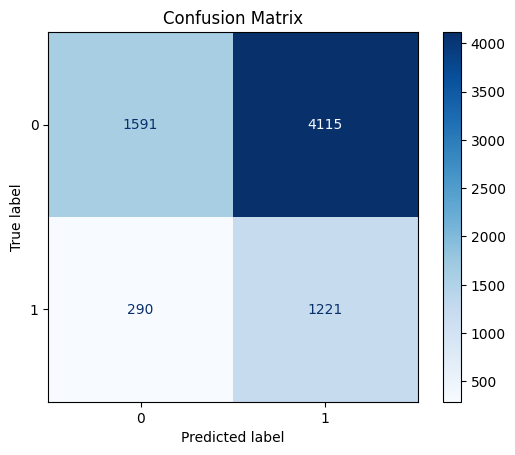

The confusion matrix has been saved as 'confusion_matrix.png' with a resolution of 300 DPI.


In [ ]:
true_labels = df_unseen['label']
predicted_labels = unseen_predictions

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')

# Save the figure
plt.savefig('/content/confusion_matrix.png', dpi=300)

# Show the plot
plt.show()

print("The confusion matrix has been saved as 'confusion_matrix.png' with a resolution of 300 DPI.")

# Testing

In [ ]:
# Basic Spam Message
sentence_1 = "Congratulations! You've won a $1000 gift card. Click here to claim now."
test_sentence = [sentence_1]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Complex Non-Spam Message
sentence_2 = "Hi team, remember our meeting is rescheduled to 10:00 AM tomorrow. Please prepare your reports accordingly."
test_sentence = [sentence_2]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Not Spam


In [ ]:
# Spam with Misleading Information
sentence_3 = "Amazing opportunity to work from home and earn up to $5000 per month. No experience needed. DM for details."
test_sentence = [sentence_3]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Non-Spam with Casual Language
sentence_4 = "Hey! Are we still on for the movie night this Friday? Can't wait to see you all 😊"
test_sentence = [sentence_4]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Spam with Heavy Emoji Use
sentence_5 = "🔥🔥Hot Deal Just For You!🔥🔥 Buy 1 Get 2 FREE!!! Exclusive offer just for you, click the link NOW!!! ➡️➡️[URL]⬅️⬅️"
test_sentence = [sentence_5]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Non-Spam with Technical Content
sentence_6 = "The latest version update includes several bug fixes and performance improvements that enhance the software's security features and user interface."
test_sentence = [sentence_6]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Not Spam


In [ ]:
# Spam Mimicking Official Communication
sentence_7 = "Notice: Your bank account has been temporarily suspended due to suspicious activities. Please verify your identity here [URL] to reactivate immediately."
test_sentence = [sentence_7]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Non-Spam Formal Invitation
sentence_8 = "You are cordially invited to the annual gala hosted by [Company Name]. Please RSVP by [Date]."
test_sentence = [sentence_8]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Not Spam


In [ ]:
# Spam with Urgency and Fear Tactics
sentence_9 = "Alert: Your email account will be permanently disabled unless you log in through the following link within 24 hours."
test_sentence = [sentence_9]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam


In [ ]:
# Multilingual Spam Message
sentence_10 =  "¡Felicidades! Has sido seleccionado para recibir un premio exclusivo. Haz clic aquí para reclamar tu premio ahora."
test_sentence = [sentence_10]
test_sentence_tfidf = tfidf_vectorizer.transform(test_sentence)
predicted_label = clf.predict(test_sentence_tfidf)
print(f"The sentence is classified as: {'Spam' if predicted_label[0] == 1 else 'Not Spam'}")

The sentence is classified as: Spam
